In [ ]:
import numpy as np
import os
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname((os.path.abspath(os.getcwd()))))

from utils import fft_denoise, wavelet_denoise, compute_metrics
from datasets import ECGDataset
from models import *

model_dict = {
	"U-Net": UNet,
	"ECA-UNet": ECAUNet,
	"CIAD-UNet": CIADUNet,
	"SE-UNet": SEUNet,
	"CBAM-UNet": CBAMUNet,
}


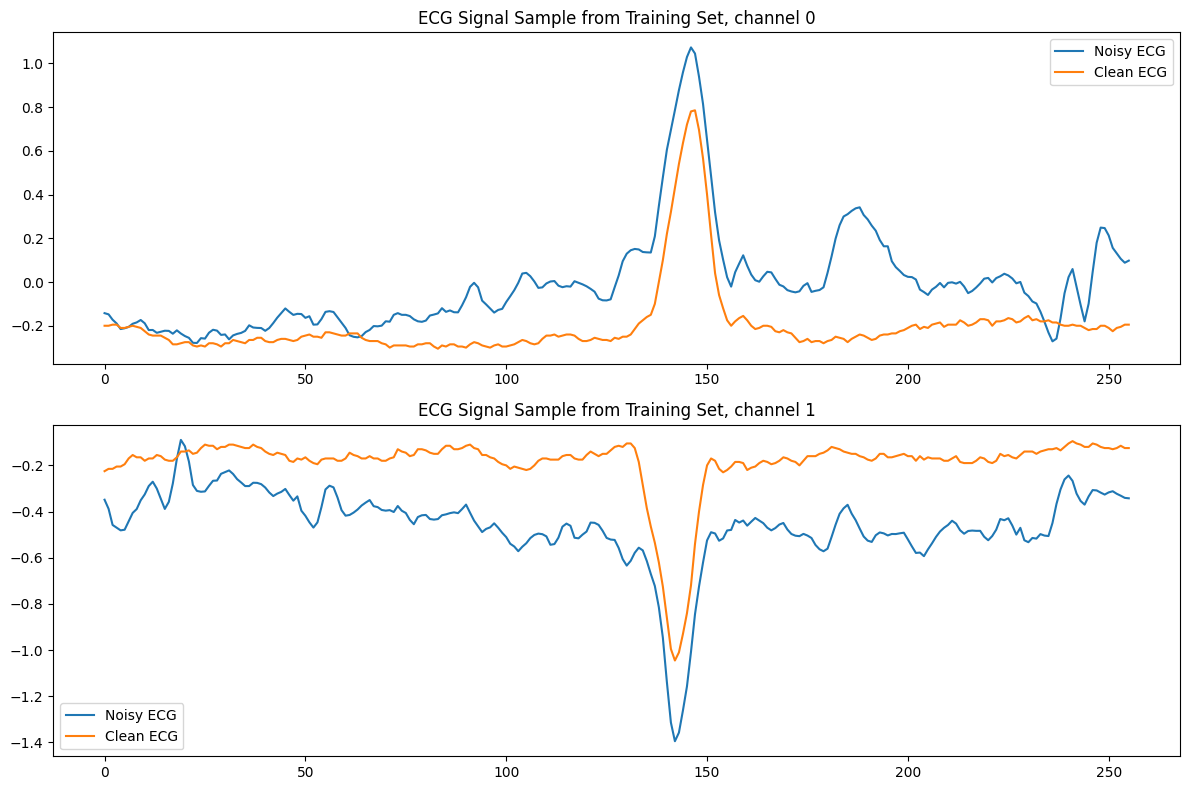

In [28]:
noise_type = "emb"
snr_db = -4

dataset = ECGDataset(
	split="test",
	noise_type=noise_type,
	snr_db=snr_db,
	split_dir="./data_split",
)
idx = np.random.randint(0, len(dataset) - 1)
noisy, clean = dataset[idx]

mean, std = dataset.get_stats()

mean = mean.squeeze(0).permute(1, 0) # (channels, length)
std = std.squeeze(0).permute(1, 0)
ori_noisy = noisy * std + mean

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(ori_noisy[0].numpy(), label="Noisy ECG")
plt.plot(clean[0].numpy(), label="Clean ECG")
plt.legend()
plt.title("ECG Signal Sample from Training Set, channel 0")

plt.subplot(2, 1, 2)
plt.plot(ori_noisy[1].numpy(), label="Noisy ECG")
plt.plot(clean[1].numpy(), label="Clean ECG")
plt.legend()
plt.title("ECG Signal Sample from Training Set, channel 1")

plt.tight_layout()
plt.show()

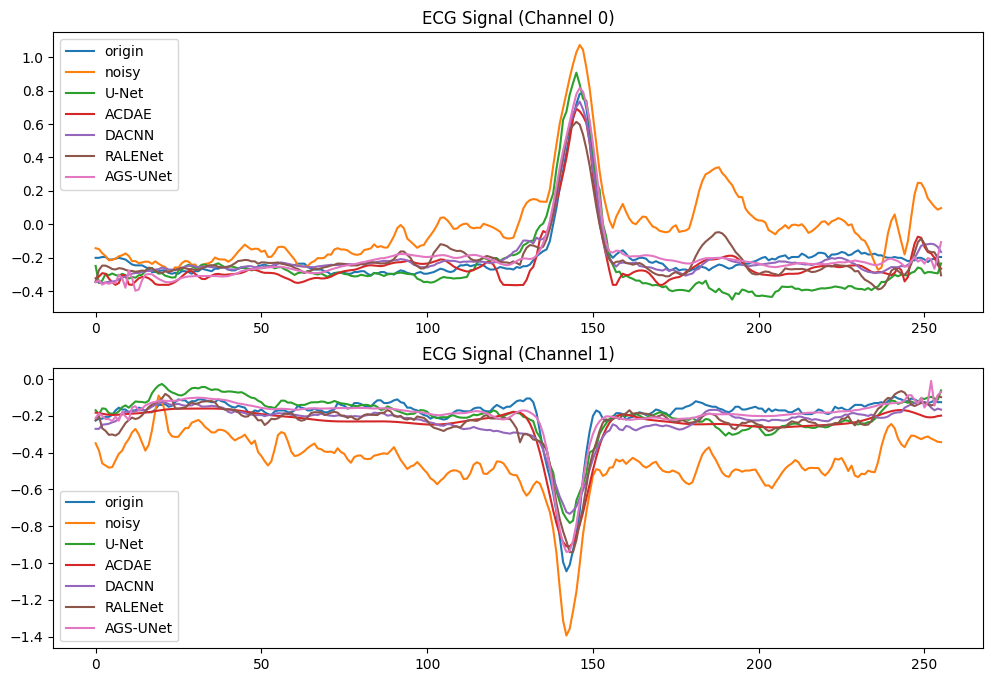

In [ ]:
model_name = "U-Net"  # Change this to test different models

denoised_output_dict = {}
for model_name in model_dict.keys():
	model = model_dict[model_name]()
	model.load_state_dict(torch.load(f"./checkpoints/best_{model_name}_{noise_type}_snr_{snr_db}.pth", map_location="cpu"))
	model.eval()

	with torch.no_grad():
		noisy_input = torch.tensor(noisy)
		noisy_input = noisy_input.unsqueeze(0)  # Add batch dimension
		denoised_output = model(noisy_input)

	denoised_output = denoised_output.squeeze(0)  # Remove batch dimension

	denoised_output = denoised_output * std + mean
	
	denoised_output_dict[model_name] = denoised_output


plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(clean[0], label="origin")
plt.plot(ori_noisy[0], label="noisy")
for model_name, denoised_output in denoised_output_dict.items():
	plt.plot(denoised_output[0], label=f"{model_name}")
plt.title("ECG Signal (Channel 0)")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(clean[1], label="origin")
plt.plot(ori_noisy[1], label="noisy")
for model_name, denoised_output in denoised_output_dict.items():
	plt.plot(denoised_output[1], label=f"{model_name}")
plt.title("ECG Signal (Channel 1)")
plt.legend()

plt.show()